In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import datetime
import os
from tueplots import bundles
from tueplots.constants.color import rgb
import sklearn as sk
from sklearn.decomposition import PCA
import seaborn as sns
import dload
import geopandas
from shapely.geometry import Point, Polygon


In [6]:
accidents = pd.read_csv('FARS2021NationalCSV/accident.csv',encoding='WINDOWS-1252',low_memory=False)
drugs = pd.read_csv('FARS2021NationalCSV/drugs.csv',encoding='WINDOWS-1252',low_memory=False) 
person = pd.read_csv('FARS2021NationalCSV/person.csv',encoding='WINDOWS-1252',low_memory=False)


### Here we should do the data preprocessibg (especially merging the dataset removing bad values etc)



''' Other data '''

## This is the amount of lane miles by every state, ordered alphaetically (like in the lists we are using. 
## Data is taken from https://blog.cubitplanning.com/2010/02/road-miles-by-state/
## There is a reliable data source linked. @TODO Use data from actual reputable source-


states = [210531,36009,146465,210729,396540,185486,45916,14069,3445,275376,272662,9799,107568,306658,202707,235549,286606,166971,134115,46736,71129,77730,256579,290618,162088,	277504,150446,193996,100805,33391,85108,150216,240489,229011,178845,262492,238754,162101,251708,12664,166594,166635,203850,683533,102031,29273,164132,167632,80167,239318,62620]
## US census, ordered by states
state_pop = pd.read_csv('Daten/population.csv')
 ##Last 'state is Puerto Rico, hence we dont include it. First lines include meta data, that is irrelevant to us.
state_pop = state_pop.iloc[14:]
state_pop = state_pop.iloc[:-1]
## We remove unwanted columns (all besides state name and amount), so the dataset becomes easier to work with. 
col = state_pop.columns.values
col = np.delete(col,[4,7])
state_pop = state_pop.drop(col,axis=1)

#Prepare the state drawing of the US.
US_state_shape = geopandas.read_file('Daten/States shape data/cb_2018_us_state_500k.shp')
US_state_shape['STATENAME'] = US_state_shape['NAME']
print(US_state_shape.head())

save_US = US_state_shape.copy()

Cannot find header.dxf (GDAL_DATA is not defined)


  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry       STATENAME  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...     Mississippi  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  North Carolina  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...        Oklahoma  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...        Virginia  
4  POLYGON ((-82.64320 38.16909

Histogram drunk drivers


In [7]:
''' Note: We are lacking the preprocessing step here. Thus currently not runable.'''
#
### Prepare array the historgram 
histWhole = [0 for k in range(100)]
histDrunk = [0 for k in range(100)]
for i in range(100):
    for j in range(len(ages)):
        if ages[j] == i: 
            histWhole[i] = histWhole[i] + 1
            if alc[j] != 0:
                histDrunk[i] = histDrunk[i] + 1
                
### Plot the histograms
plt.title('Histogram of Accidents by Age')
plt.xlabel('Age')
plt.ylabel('Amounts')
plt.bar([i for i in range(100)],histWhole,label='All')
plt.bar([i for i in range(100)],histDrunk,label='Drunk')
plt.legend()               



NameError: name 'ages' is not defined

Age group drunk drivers

(again not usable, preprocessing. Check other file if needed)




In [17]:
### Make into age group
bins = [i for i in range(17)]
res = [0 for i in range(17)]
for x in ages:
    if x >= 85: res[-1] = res[-1] +1
    else:
        x = x - (x % 5)
        b = int(x / 5)
        res[b] = res[b] +1
tot = len(ages)
procent_age = [i*100 / tot for i in res]

In [19]:
### Collect age data of the US government
us_cens = pd.read_csv('US_CENSUS/2021agesex_table1.csv',encoding='WINDOWS-1252',low_memory=False)
ag = us_cens['Unnamed: 2'].tolist() ##The columns have bad names
ag[6]
## Make lists of age distribution
x = [i for i in range(17)]
y = [float(ag[i+6]) for i in range(17)] 

Text(0.5, 0, 'Age Group, blocks of 5 years')

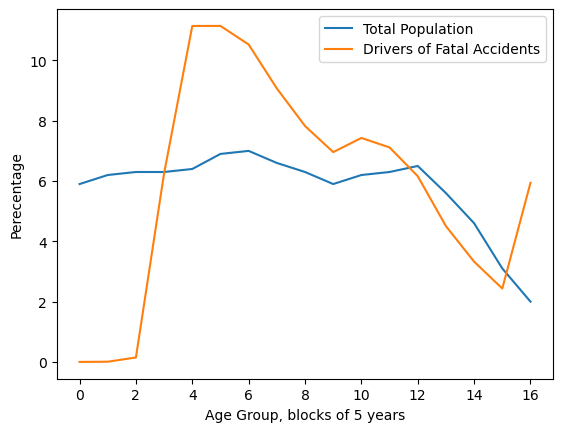

In [23]:
## Plot
### Todo: make nice
plt.plot(x,y, label='Total Population')
plt.plot(x,procent_age,label='Drivers of Fatal Accidents')
plt.legend()
plt.ylabel('Perecentage')
plt.xlabel('Age Group, blocks of 5 years')

Plot all accidents on map


In [24]:
## Better visibility
accidents = accidents.loc[accidents['LONGITUD'] <= 200] ##Redundant after preprocessing
accidents = accidents.loc[accidents['STATENAME'] != 'Hawaii']
accidents = accidents.loc[accidents['STATENAME'] != 'Alaska']


In [25]:
''' Plot accidents on map '''
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(accidents['LONGITUD'], accidents['LATITUDE'])]
geo_data = gpd.GeoDataFrame(accidents,crs=crs,geometry=geometry)

C:\Users\paulh\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

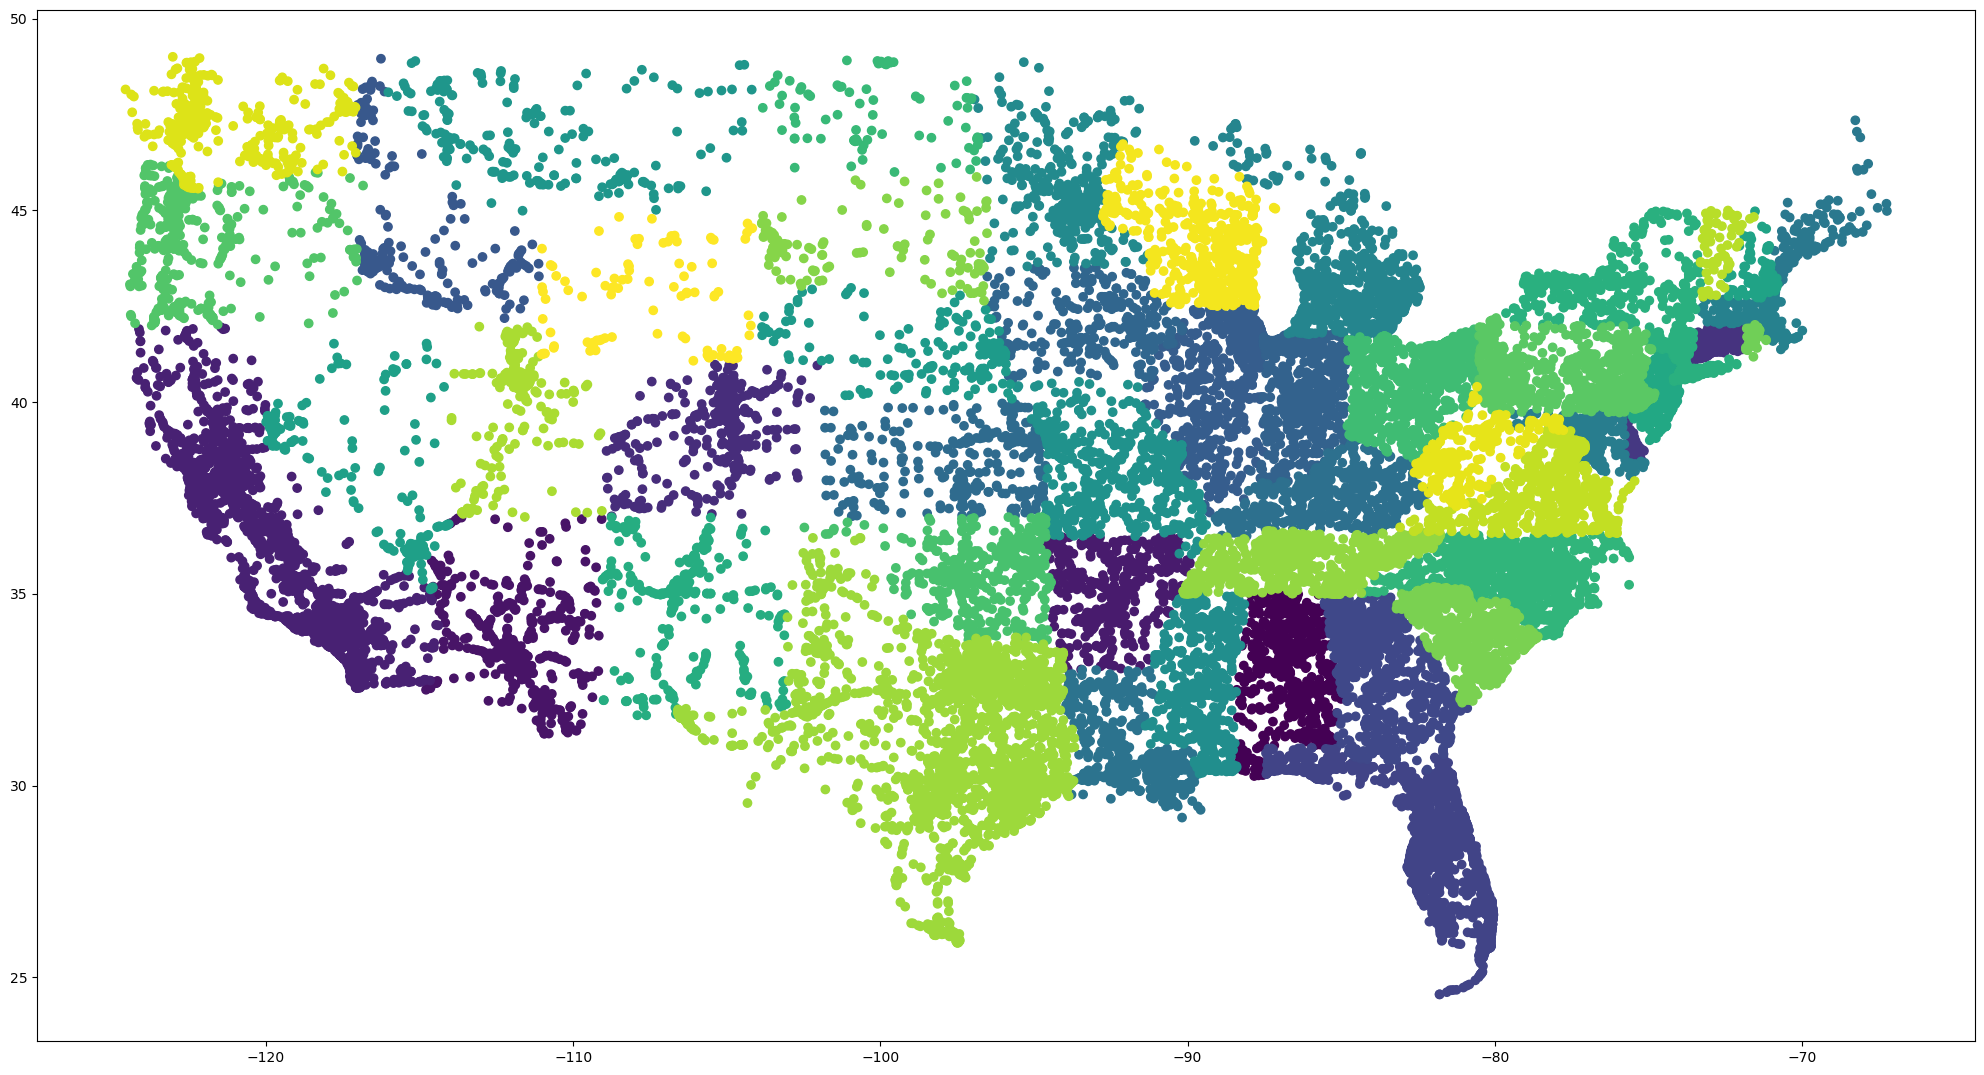

In [29]:
## TODO improve plot
geo_data.plot(geo_data['STATE'],figsize=(25,25))



Accidents by lane miles 

In [ ]:
## Data is calculated
pop_vals = state_pop['POPESTIMATE2021'].values
statenames = state_pop['NAME'].values
counts = []
## For every state count amount of accidents.
# TODO remove non unique ids. (maybe, depending on what we want)
for x in statenames:
    counts.append(accidents['STATENAME'].value_counts()[x])    
state_pop.insert(2,'Accidents/State',counts,True)
state_pop.insert(3,'Lane Miles',states,True)
## res is the value we wanted to calculate
res = np.array(counts) / ( states * pop_val )
b = np.sort(res) ## We want to rescale the map accordingly
state_pop.insert(4,'AccidentsPerCapitaPerLaneMile',res,True)
state_pop.rename(columns = {'NAME':'STATENAME'}, inplace = True) 

In [ ]:
### Plot
US_state_shape = save_US.copy()
US_state_shape = geopandas.GeoDataFrame(pd.merge(US_state_shape,state_pop, on=['STATENAME']))

US_state_shape.plot(column='AccidentsPerCapitaPerLaneMile',vmin=b[0],vmax=b[-3])
plt.xlim(-180,-60)
plt.ylim(20,None)